# Modélisation et évaluation des modèles

**Auteur :** Mehdi MUNIM

**Date :** 2023-11-26

**Description :**

Ce notebook entraîne et évalue différents modèles de Machine Learning pour la classification de sentiment sur les données de tweets prétraitées.

## 1- Importation des librairies

In [2]:
#@title 1. Importation des librairies

# Data manipulation and processing
import pandas as pd
import numpy as np
import pickle

# Machine learning
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# System and custom modules
import sys
sys.path.append('../src')
import model
import evaluation

## 2. Chargement des données

In [3]:
#@title 2.1 Chargement des données

# Chemin d'accès au dossier data
data_path = '../data/processed/'

# Charger les données prétraitées

## Données non vectorisées
X_train = pickle.load(open(data_path + 'X_train.pickle', 'rb'))
X_test = pickle.load(open(data_path + 'X_test.pickle', 'rb'))

## Labels
y_train = pickle.load(open(data_path + 'y_train.pickle', 'rb'))
y_test = pickle.load(open(data_path + 'y_test.pickle', 'rb'))

## Vectorisées TF-IDF
X_train_tfidf = pickle.load(open(data_path + 'X_train_tfidf.pickle', 'rb'))
X_test_tfidf = pickle.load(open(data_path + 'X_test_tfidf.pickle', 'rb'))

## Word2vec
X_train_w2v = pickle.load(open(data_path + 'X_train_word2vec.pickle', 'rb'))
X_test_w2v = pickle.load(open(data_path + 'X_test_word2vec.pickle', 'rb'))


## Doc2Vec
X_train_d2v = pickle.load(open(data_path + 'X_train_doc2vec.pickle', 'rb'))
X_test_d2v = pickle.load(open(data_path + 'X_test_doc2vec.pickle', 'rb'))


## 3. Entraînement et évaluation des modèles

### 3.1 - Régression logistique (Baseline)

Accuracy: 0.5875
Precision: 0.5739
Recall: 0.5996
F1-score: 0.5865
Prediction Time: 0.0030 seconds


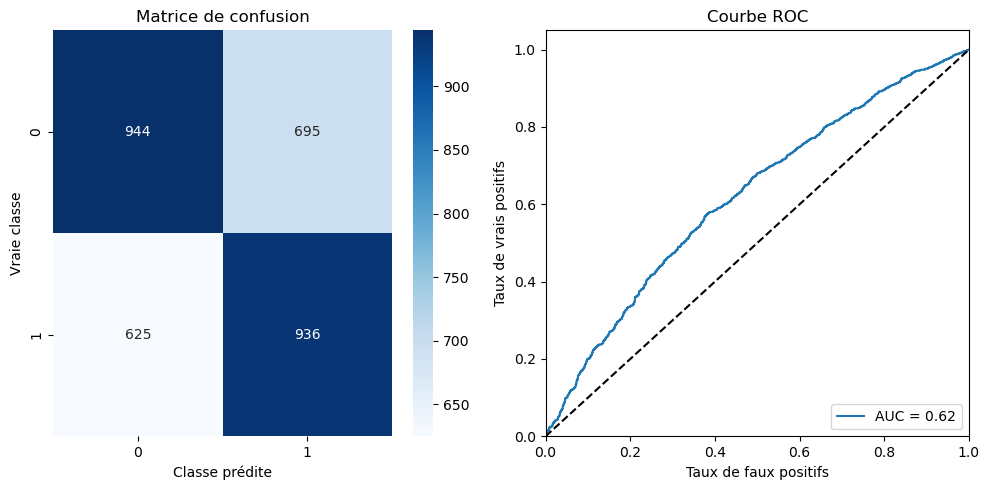

2024/12/03 18:29:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [6]:
#@title 3.1 Entraînement et évaluation du modèle de régression logistique avec MLflow

import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression

# Créer et entraîner le modèle de régression logistique
model_lr = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    model_lr.fit(X_train_d2v, y_train)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lr, X_test_d2v, y_test)

    # Enregistrer les paramètres
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("solver", "liblinear")
    mlflow.log_param("max_iter", 1000)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)  # Enregistrer le predict_time

    # Ajouter un tag
    mlflow.set_tag("model_name", "LogisticRegression")
    
    # Enregistrer le modèle
    mlflow.sklearn.log_model(model_lr, "model_lr")

### 3.2 - Modèle MLP

Epoch 1/10
320/320 [==============================] - 2s 3ms/step - loss: 0.6913 - accuracy: 0.5149 - val_loss: 0.6846 - val_accuracy: 0.5746
Epoch 2/10
320/320 [==============================] - 1s 3ms/step - loss: 0.6810 - accuracy: 0.5595 - val_loss: 0.6731 - val_accuracy: 0.5926
Epoch 3/10
320/320 [==============================] - 1s 3ms/step - loss: 0.6780 - accuracy: 0.5722 - val_loss: 0.6692 - val_accuracy: 0.5852
Epoch 4/10
320/320 [==============================] - 1s 3ms/step - loss: 0.6737 - accuracy: 0.5800 - val_loss: 0.6667 - val_accuracy: 0.5926
Epoch 5/10
320/320 [==============================] - 1s 3ms/step - loss: 0.6715 - accuracy: 0.5771 - val_loss: 0.6658 - val_accuracy: 0.5855
Epoch 6/10
320/320 [==============================] - 1s 4ms/step - loss: 0.6688 - accuracy: 0.5818 - val_loss: 0.6645 - val_accuracy: 0.5863
Epoch 7/10
320/320 [==============================] - 1s 3ms/step - loss: 0.6659 - accuracy: 0.5917 - val_loss: 0.6651 - val_accuracy: 0.5887
Epoch 

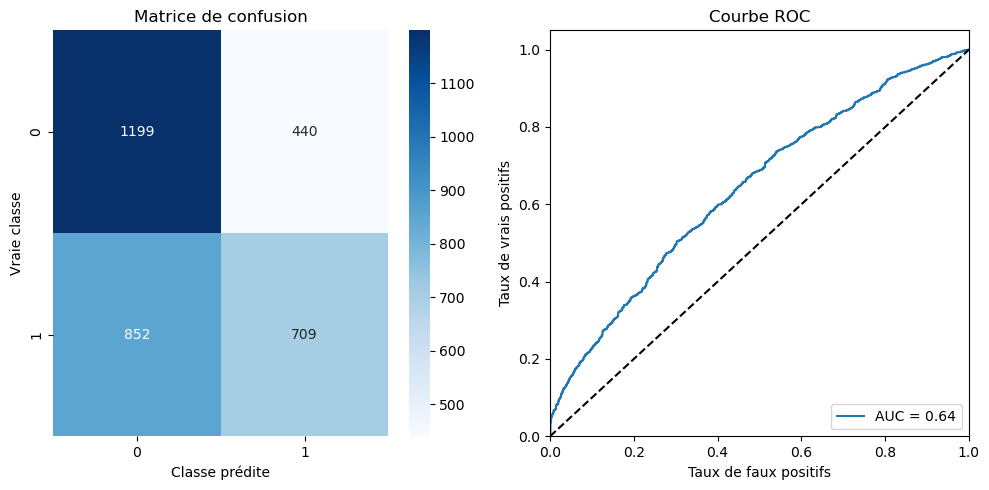

2024/12/03 18:28:25 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpykxk5mj3/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpykxk5mj3/model/data/model/assets
/home/mehdi/miniconda3/envs/sentiment_analysis/lib/python3.8/site-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/12/03 18:28:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [4]:
#@title 3.2 Entraînement et évaluation du modèle MLP avec MLflow

import mlflow
import mlflow.keras

# Créer et entraîner le modèle MLP
model_mlp = model.create_mlp_model(input_shape=(X_train_w2v.shape[1],))

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    model_mlp.fit(X_train_d2v, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_mlp, X_test_d2v, y_test)

    # Enregistrer les paramètres
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)  # Ajout du predict_time

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "MLP")
    
    # Enregistrer le modèle
    mlflow.keras.log_model(model_mlp, "model_mlp")

### 3.3 - Modèle CNN

Epoch 1/10
320/320 [==============================] - 3s 7ms/step - loss: 0.6932 - accuracy: 0.5046 - val_loss: 0.6930 - val_accuracy: 0.5094
Epoch 2/10
320/320 [==============================] - 3s 8ms/step - loss: 0.6928 - accuracy: 0.5230 - val_loss: 0.6928 - val_accuracy: 0.5043
Epoch 3/10
320/320 [==============================] - 2s 8ms/step - loss: 0.6921 - accuracy: 0.5188 - val_loss: 0.6911 - val_accuracy: 0.5129
Epoch 4/10
320/320 [==============================] - 2s 7ms/step - loss: 0.6900 - accuracy: 0.5424 - val_loss: 0.6899 - val_accuracy: 0.5086
Epoch 5/10
320/320 [==============================] - 2s 7ms/step - loss: 0.6861 - accuracy: 0.5607 - val_loss: 0.6835 - val_accuracy: 0.5465
Epoch 6/10
320/320 [==============================] - 2s 7ms/step - loss: 0.6815 - accuracy: 0.5670 - val_loss: 0.6788 - val_accuracy: 0.5637
Epoch 7/10
320/320 [==============================] - 2s 7ms/step - loss: 0.6785 - accuracy: 0.5792 - val_loss: 0.6757 - val_accuracy: 0.5734
Epoch 

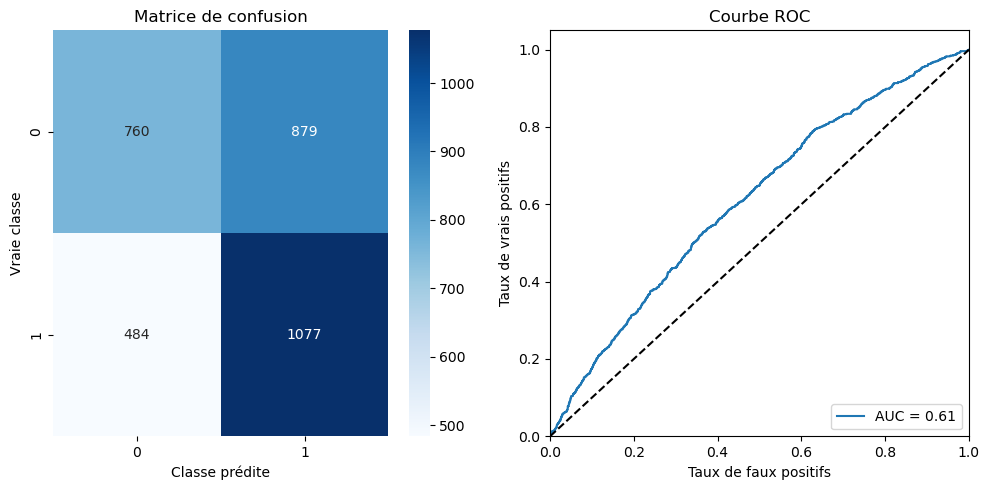

2024/12/03 18:30:24 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpjtz5dgxk/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpjtz5dgxk/model/data/model/assets
2024/12/03 18:30:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [7]:
#@title 3.3 Entraînement et évaluation du modèle CNN avec MLflow

import mlflow
import mlflow.keras

# Reshape les données pour le modèle CNN
X_train_cnn = np.reshape(X_train_d2v, (X_train_d2v.shape[0], X_train_d2v.shape[1], 1))
X_test_cnn = np.reshape(X_test_d2v, (X_test_d2v.shape[0], X_test_d2v.shape[1], 1))

# Créer le modèle CNN
model_cnn = model.create_cnn_model(input_shape=(X_train_cnn.shape[1], 1))

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    model_cnn.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_cnn, X_test_cnn, y_test)

    # Enregistrer les paramètres
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score",  f1)
    mlflow.log_metric("predict_time", predict_time)  # Ajout du predict_time

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "CNN")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_cnn, "model_cnn")

### 3.4 - Modèle LSTM + Embeddding Word2Vec

Epoch 1/10
640/640 [==============================] - 24s 34ms/step - loss: 0.6979 - accuracy: 0.4923 - val_loss: 0.6927 - val_accuracy: 0.5137
Epoch 2/10
640/640 [==============================] - 20s 31ms/step - loss: 0.6932 - accuracy: 0.5123 - val_loss: 0.6921 - val_accuracy: 0.5160
Epoch 3/10
640/640 [==============================] - 26s 41ms/step - loss: 0.6928 - accuracy: 0.5107 - val_loss: 0.6928 - val_accuracy: 0.5066
Epoch 4/10
640/640 [==============================] - 21s 33ms/step - loss: 0.6920 - accuracy: 0.5203 - val_loss: 0.6915 - val_accuracy: 0.5316
Epoch 5/10
640/640 [==============================] - 26s 40ms/step - loss: 0.6914 - accuracy: 0.5248 - val_loss: 0.6915 - val_accuracy: 0.5262
Epoch 6/10
640/640 [==============================] - 25s 39ms/step - loss: 0.6909 - accuracy: 0.5231 - val_loss: 0.6908 - val_accuracy: 0.5285
Epoch 7/10
640/640 [==============================] - 28s 44ms/step - loss: 0.6903 - accuracy: 0.5312 - val_loss: 0.6909 - val_accuracy:

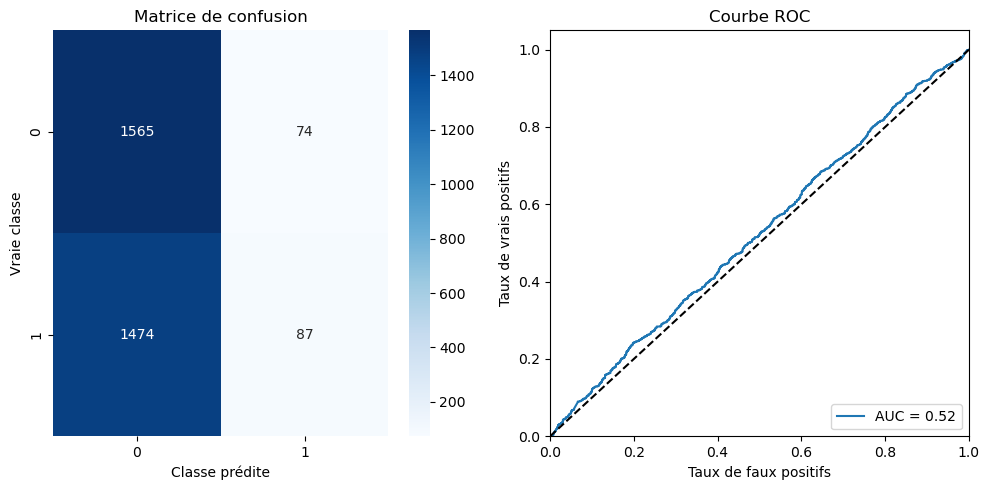

2024/12/03 18:13:03 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmp8erhufsi/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp8erhufsi/model/data/model/assets
2024/12/03 18:13:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Epoch 1/10
320/320 [==============================] - 22s 64ms/step - loss: 0.6963 - accuracy: 0.5071 - val_loss: 0.6986 - val_accuracy: 0.4957
Epoch 2/10
320/320 [==============================] - 22s 68ms/step - loss: 0.6942 - accuracy: 0.5066 - val_loss: 0.6924 - val_accuracy: 0.5188
Epoch 3/10
320/320 [==============================] - 19s 59ms/step - loss: 0.6924 - accuracy: 0.5142 - val_loss: 0.7004 - val_accuracy: 0.5066
Epoch 4/10
320/320 [==============================] - 17s 52ms/step - loss: 0.6928 - accuracy: 0.5139 - val_loss: 0.6916 - val_accuracy: 0.5246
Epoch 5/10
320/320 [==============================] - 18s 56ms/step - loss: 0.6918 - accuracy: 0.5132 - val_loss: 0.6923 - val_accuracy: 0.5141
Epoch 6/10
320/320 [==============================] - 20s 62ms/step - loss: 0.6918 - accuracy: 0.5191 - val_loss: 0.6917 - val_accuracy: 0.5227
Epoch 7/10
320/320 [==============================] - 20s 61ms/step - loss: 0.6914 - accuracy: 0.5251 - val_loss: 0.6914 - val_accuracy:

KeyboardInterrupt: 

In [17]:
#@title 3.8 Entraînement et évaluation du modèle LSTM avec Word2Vec et MLflow (optimisation du batch_size)

import mlflow
import mlflow.keras
from gensim.models import Word2Vec

# Entraîner le modèle Word2Vec sur les tweets prétraités
sentences = [tweet.split() for tweet in X_train]
model_w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Créer la matrice d'embedding
embedding_matrix = np.zeros((len(model_w2v.wv), 100))

# Itérer sur les mots du vocabulaire
for i, word in enumerate(model_w2v.wv.index_to_key):  # Utiliser index_to_key pour obtenir les mots
    embedding_matrix[i] = model_w2v.wv[word]

# Entraîner le modèle sur les données d'entraînement
X_train_w2v = [[model_w2v.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_train]
X_test_w2v = [[model_w2v.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_test]

# Remplir les séquences avec des zéros pour qu'elles aient toutes la même longueur
max_length = 100  # Définir la longueur maximale des séquences
X_train_w2v = pad_sequences(X_train_w2v, maxlen=max_length)
X_test_w2v = pad_sequences(X_test_w2v, maxlen=max_length)

# Définir les valeurs de batch_size à tester
batch_sizes = [16, 32, 64, 128]

for batch_size in batch_sizes:
    with mlflow.start_run():
        # Créer le modèle LSTM
        model_lstm = model.create_lstm_model(input_shape=(embedding_matrix.shape[0], embedding_matrix.shape[1]),
                                            embedding_matrix = embedding_matrix)

        # Entraîner le modèle avec le batch_size actuel
        model_lstm.fit(X_train_w2v, y_train, epochs=10, batch_size=batch_size, validation_split=0.2)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lstm, X_test_w2v, y_test)

        # Enregistrer les paramètres
        mlflow.log_param("model", "LSTM")
        mlflow.log_param("embedding", "Word2Vec")
        mlflow.log_param("epochs", 10)
        mlflow.log_param("batch_size", batch_size)

        # Enregistrer les métriques
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

        # Ajouter un tag pour identifier le modèle
        mlflow.set_tag("model_name", "LSTM_w2v")

        # Enregistrer le modèle
        mlflow.keras.log_model(model_lstm, "model_lstm_w2v")

### 3.5 - Modèle LSTM + Embeddding FastText

Epoch 1/10
320/320 [==============================] - 17s 48ms/step - loss: 0.6979 - accuracy: 0.5067 - val_loss: 0.6976 - val_accuracy: 0.4965
Epoch 2/10
320/320 [==============================] - 15s 47ms/step - loss: 0.6939 - accuracy: 0.5091 - val_loss: 0.6955 - val_accuracy: 0.5168
Epoch 3/10
320/320 [==============================] - 19s 58ms/step - loss: 0.6931 - accuracy: 0.5164 - val_loss: 0.6942 - val_accuracy: 0.5023
Epoch 4/10
320/320 [==============================] - 21s 66ms/step - loss: 0.6933 - accuracy: 0.5129 - val_loss: 0.6947 - val_accuracy: 0.5035
Epoch 5/10
320/320 [==============================] - 18s 57ms/step - loss: 0.6927 - accuracy: 0.5096 - val_loss: 0.6954 - val_accuracy: 0.5039
Epoch 6/10
320/320 [==============================] - 16s 49ms/step - loss: 0.6924 - accuracy: 0.5165 - val_loss: 0.6949 - val_accuracy: 0.5105
Epoch 7/10
320/320 [==============================] - 15s 46ms/step - loss: 0.6921 - accuracy: 0.5197 - val_loss: 0.6946 - val_accuracy:

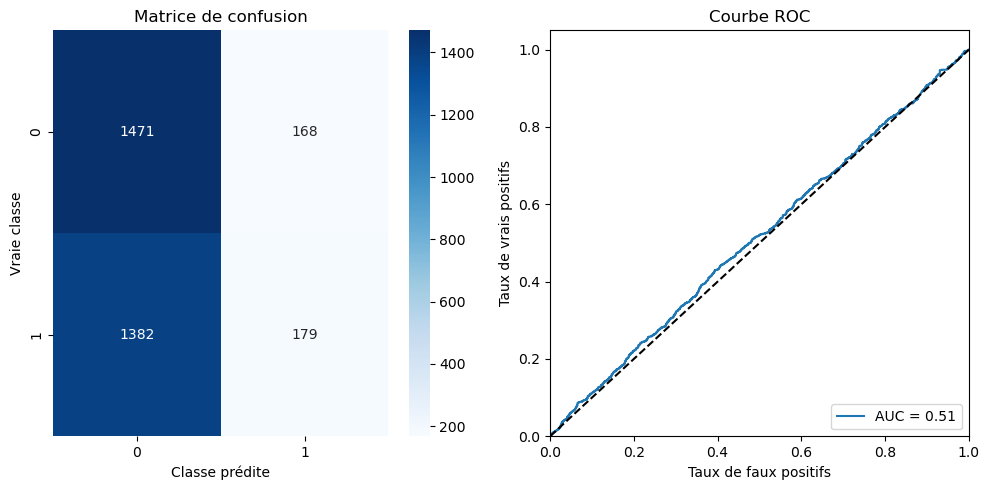

2024/12/03 17:57:58 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpkq1rnd44/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpkq1rnd44/model/data/model/assets
2024/12/03 17:58:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [7]:
#@title 3.7 Entraînement et évaluation du modèle LSTM avec FastText et MLflow

import mlflow
import mlflow.keras
from gensim.models import FastText

# Entraîner le modèle FastText sur les tweets prétraités
sentences = [tweet.split() for tweet in X_train]
model_ft = FastText(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Créer la matrice d'embedding
embedding_matrix = np.zeros((len(model_ft.wv), 100))  # Forme (vocab_size, 100)

# Itérer sur les mots du vocabulaire
for i, word in enumerate(model_ft.wv.index_to_key):  # Utiliser index_to_key pour obtenir les mots
    embedding_matrix[i] = model_ft.wv[word]

# Définir le modèle LSTM avec la couche d'embedding FastText
model_lstm_ft = model.create_lstm_model(input_shape=(embedding_matrix.shape[0], embedding_matrix.shape[1]),
                                       embedding_matrix= embedding_matrix)

# Entraîner le modèle sur les données d'entraînement
X_train_ft = [[model_ft.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_train]
X_test_ft = [[model_ft.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_test]

# Remplir les séquences avec des zéros pour qu'elles aient toutes la même longueur
max_length = 100  # Définir la longueur maximale des séquences
X_train_ft = pad_sequences(X_train_ft, maxlen=max_length)
X_test_ft = pad_sequences(X_test_ft, maxlen=max_length)

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    history = model_lstm_ft.fit(X_train_ft, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lstm_ft, X_test_ft, y_test)

    # Enregistrer les paramètres
    mlflow.log_param("model", "LSTM")
    mlflow.log_param("embedding", "FastText")
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "LSTM_ft")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_lstm_ft, "model_lstm_ft")

### 3.6 - Modèle BERT

In [10]:
#@title 3.5 Entraînement et évaluation du modèle BERT avec MLflow

import mlflow
import mlflow.keras

# Créer et entraîner le modèle BERT
model_bert, tokenizer = model.create_bert_model("bert-base-uncased")

# Tokenizer les tweets d'entraînement et de test
X_train_bert = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors="tf")
X_test_bert = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors="tf")

# Convertir les labels en tenseurs
y_train_bert = tf.convert_to_tensor(y_train)
y_test_bert = tf.convert_to_tensor(y_test)

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    history = model_bert.fit(
        x={"input_ids": X_train_bert["input_ids"], "attention_mask": X_train_bert["attention_mask"]},
        y=y_train_bert,
        validation_split=0.2,
        epochs=3,
        batch_size=32,
    )

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_bert,
                                                                 {"input_ids": X_test_bert["input_ids"], "attention_mask": X_test_bert["attention_mask"]},
                                                                 y_test_bert)

    # Enregistrer les paramètres
    mlflow.log_param("model", "BERT")
    mlflow.log_param("model_name", "bert-base-uncased")
    mlflow.log_param("epochs", 3)
    mlflow.log_param("batch_size", 32)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score",  f1)
    mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "BERT")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_bert, "model_bert")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
  3/320 [..............................] - ETA: 1:08:31 - loss: 0.8807 - accuracy: 0.5312

KeyboardInterrupt: 

### 3.7 - Modèle USE

In [ ]:
#@title 3.6 Entraînement et évaluation du modèle USE avec MLflow

import mlflow
import mlflow.keras
import tensorflow_hub as hub

# Charger le modèle USE
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Encoder les tweets
X_train_use = embed(X_train)
X_test_use = embed(X_test)

# Créer le modèle USE
model_use = model.create_use_model(input_shape=(X_train_use.shape[1],))

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    model_use.fit(X_train_use, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_use, X_test_use, y_test)

    # Enregistrer les paramètres
    # (Ajouter ici les paramètres du modèle USE)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time).

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "USE")
    
    # Enregistrer le modèle
    mlflow.keras.log_model(model_use, "model_use")

## 4. Comparaison des modèles

In [ ]:
#@title Comparaison des modèles avec MLflow

import mlflow

# Fonction pour récupérer les métriques d'une exécution MLflow
def get_metrics_from_mlflow(model_name):
    # Rechercher l'exécution avec le tag "model_name"
    runs = mlflow.search_runs(filter_string=f"tag.model_name = '{model_name}'")
    if runs.empty:
        raise ValueError(f"Aucune exécution trouvée avec le tag 'model_name' = '{model_name}'")

    # Récupérer les métriques de la dernière exécution
    last_run = runs.iloc[-1]
    metrics = last_run.data.metrics
    return metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"], metrics["predict_time"]

# Comparaison des modèles
noms_modeles = ['LogisticRegression', 'MLP', 'LSTM_w2v', 'LSTM_ft', 'CNN', 'BERT', 'USE']

# Calculer les métriques pour chaque modèle
resultats = []
for model_name in noms_modeles:
    resultats.append(get_metrics_from_mlflow(model_name))

# Créer un DataFrame pour afficher les résultats
comparaison = pd.DataFrame(resultats, columns=['Accuracy', 'Precision', 'Recall', 'F1-score', 'Predict Time'], index=noms_modeles)

# Afficher les résultats
print(comparaison)